# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


In [2]:
import numpy as np
import torch
#import torch.nn.functional as F
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
from dqn_agent import Agent
from collections import deque

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

Episode 100	Average Score: 0.57
Episode 200	Average Score: 3.67
Episode 300	Average Score: 7.74
Episode 400	Average Score: 9.55
Episode 500	Average Score: 12.02
Episode 565	Average Score: 13.00
Environment solved in 465 episodes!	Average Score: 13.00
Episode 600	Average Score: 13.75
Episode 700	Average Score: 15.49
Episode 800	Average Score: 16.74
Episode 900	Average Score: 16.27
Episode 1000	Average Score: 17.39


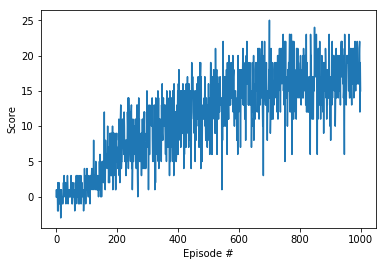

In [6]:
agent = None
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

def dqn(n_episodes=1000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
    Double_DQN = True, Priority_Replay = True, Duel_DQN = True, Priority_Replay_Paras = [0.5, 0.5, 0.5]):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        Double_DQN (bool): whether to implement Double_DQN modification
        Priority_Replay (bool): whether to implement Priority_Replay modification
        Duel_DQN (bool): whether to implement Duel_DQN modification
        Priority_Replay_Paras (list of e,a,b floats):
        e adds to all priorities, which are raised to power of a, while b is used to de-bias the q-updates
    """
    global agent
    agent = Agent(state_size, action_size, seed=0, Double_DQN=Double_DQN, Priority_Replay_Paras=Priority_Replay_Paras)
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    aux = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        agent.update_beta((i_episode-1)/(n_episodes-1))
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(int(action))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            if not aux:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                aux = True
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')            
    if not aux:
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig.savefig('scores.png')
# np.savetxt("scores.csv", scores, delimiter=",", fmt='%s')

### 5. Watch a Smart Agent!
In the next code cells, you will load the trained weights from file to watch a smart agent!

In [7]:
# Run this cell if you already have checkpoint
agent = None
state_size, action_size = len(env_info.vector_observations[0]), brain.vector_action_space_size

n_episodes=1000
max_t=500
eps_start=1.0
eps_end=0.01
eps_decay=0.995
Double_DQN = True 
Priority_Replay = True
Duel_DQN = True 
Priority_Replay_Paras = [0.5, 0.5, 0.5]

agent = Agent(state_size, action_size, seed=0, Double_DQN=Double_DQN, Priority_Replay_Paras=Priority_Replay_Paras)

In [7]:
# load the weights from saved file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]
    for j in range(500):
        action = agent.act(state)
        reward = env.step(int(action))[brain_name].rewards[0]
        state = env.step(int(action))[brain_name].vector_observations[0]
        done = env.step(int(action))[brain_name].local_done[0]        
        if done: break

When finished, you can close the environment.

In [8]:
env.close()